# Analyzing NYC High School Data
This is one on studying projects from DataQuest course.

we explored relationships between SAT (Scholastic Aptitude Test) scores and demographic factors in New York City public schools
New York City has published data on student SAT scores by high school, along with additional demographic data sets, so in this training project we have to combine a few datasets:  

- SAT scores by school - SAT scores for each high school in New York City  
- School attendance - Attendance information for each school in New York City  
- Class size - Information on class size for each school  
- AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)  
- Graduation outcomes - The percentage of students who graduated, and other outcome information  
- Demographics - Demographic information for each school  
- School survey - Surveys of parents, teachers, and students at each school  

In the end we obtain common table, which consists all needed for analysis information.
This is very importat project, because the most most of the time  during analysis is spent by Data Engeneering.  

First imported neede libraries and load the datasets

In [1]:
import pandas
import numpy
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv(r"D:\Python\Train_projects\Cleaning_data\Guided Project_ Analyzing NYC High School Data\schools\{0}".format(f))
    data[f.replace(".csv", "")] = d

In [3]:
for k in data:
    print(data[k].head())

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1

Each data set appears to either have a DBN column, or the information we need to create one. That means we can use a DBN column to combine the data sets. First we'll pinpoint matching rows from different data sets by looking for identical DBNs, then group all of their columns together in a single data set. Some of the data sets appear to contain multiple rows for each school (because the rows have duplicate DBN values). That means we’ll have to do some preprocessing to ensure that each DBN is unique within each data set. If we don't do this, we'll run into problems when we combine the data sets, because we might be merging two rows in one data set with one row in another data set.  

Read data from in the surveys and concat it to one dataframe. 

In [4]:
all_survey = pandas.read_csv(r"D:\Python\Train_projects\Cleaning_data\Guided Project_ Analyzing NYC High School Data\schools\survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv(r"D:\Python\Train_projects\Cleaning_data\Guided Project_ Analyzing NYC High School Data\schools\survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)
survey.head()

,N_p,N_s,N_t,aca_p_11,aca_s_11,aca_t_11,aca_tot_11,bn,com_p_11,com_s_11,...,t_q8c_1,t_q8c_2,t_q8c_3,t_q8c_4,t_q9,t_q9_1,t_q9_2,t_q9_3,t_q9_4,t_q9_5
0,90.0,NaN,22.0,7.8,NaN,7.9,7.9,M015,7.6,NaN,...,29.0,67.0,5.0,0.0,NaN,5.0,14.0,52.0,24.0,5.0
1,161.0,NaN,34.0,7.8,NaN,9.1,8.4,M019,7.6,NaN,...,74.0,21.0,6.0,0.0,NaN,3.0,6.0,3.0,78.0,9.0
2,367.0,NaN,42.0,8.6,NaN,7.5,8.0,M020,8.3,NaN,...,33.0,35.0,20.0,13.0,NaN,3.0,5.0,16.0,70.0,5.0
3,151.0,145.0,29.0,8.5,7.4,7.8,7.9,M034,8.2,5.9,...,21.0,45.0,28.0,7.0,NaN,0.0,18.0,32.0,39.0,11.0
4,90.0,NaN,23.0,7.9,NaN,8.1,8.0,M063,7.9,NaN,...,59.0,36.0,5.0,0.0,NaN,10.0,5.0,10.0,60.0,15.0


We can see thet here are over 2773 columns, but for analysis we need only few of it.  
There is a dictionary which help us to choose relevant columns:  
https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8  

Relevant columns is:
["dbn", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"].

These columns will give us aggregate survey data about how parents, teachers, and students feel about school safety, academic performance, and more, besides it give us the DBN, which allows us to uniquely identify the school.  
Now we remove columns, wich we don't need.

In [5]:
survey_fields = [
    "dbn", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]

The survey data has a dbn column that we'll want to convert to uppercase (DBN), like in other datasets.

In [6]:
survey["DBN"] = survey["dbn"]

Add survey data to other datasets

In [7]:
data["survey"] = survey

When we explored all of the data sets, we noticed that some of them, like class_size and hs_directory, don't have a DBN column. hs_directory does have a dbn column, though, so we can just rename it.

In [8]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


It look like DBN is just a combination of the CSD and SCHOOL CODE columns in the class_size data. The main difference is that the DBN is padded, so that the CSD portion of it always consists of two digits, so we need to add a leading 0 to the CSD if the CSD is less than two digits long.

In [9]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

Instead of use the SAT scores for the different sections of the exam we can calculate total score. Before we can generate this column, we'll need to convert the SAT Math Avg. Score, SAT Critical Reading Avg. Score, and SAT Writing Avg. Score columns to a numeric data type. 

In [10]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce") 

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

###### Parsing Geographic Coordinates for Schools
The coordinates are currently in the text field Location 1 in the hs_directory data set.

In [11]:
data['hs_directory']['Location 1'].head()

0    883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...
1    1110 Boston Road\nBronx, NY 10456\n(40.8276026...
2    1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...
3    411 Pearl Street\nNew York, NY 10038\n(40.7106...
4    160-20 Goethals Avenue\nJamaica, NY 11432\n(40...
Name: Location 1, dtype: object

From text we need only information in parentheses - latitude and longitude.  
We can do the extraction with a regular expression.

In [12]:
lat_log = re.findall("\(.+\)", "1110 Boston Road\nBronx, NY 10456\n(40.8276026690005, -73.90447525699966)")
lat_log

['(40.8276026690005, -73.90447525699966)']

We have a string with values of latitude and longitude.  
Than we need to split it and replace few sign. Let's write function for extraction of latitude and longitude.

In [13]:
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

Than we need to convert string in numerical data.

In [14]:
data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

Datasets like class_size have duplicate DBN values. We'll need to condense these data sets so that each value in the DBN column is unique

In [15]:
data["class_size"].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


In [16]:
data["class_size"]['GRADE '].value_counts()

09-12      10644
MS Core     4762
0K-09       1384
0K          1237
01          1185
02          1167
03          1143
04          1140
05          1086
06           846
07           778
08           735
09            20
Name: GRADE , dtype: int64

Because we're dealing with high schools, we need only grades 9 - 12

In [17]:
data["class_size"]['PROGRAM TYPE'].value_counts()

GEN ED     14545
CTT         7460
SPEC ED     3653
G&T          469
Name: PROGRAM TYPE, dtype: int64

Let's take the largest group - GEN ED

In [18]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

In [19]:
class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292


DBN still isn't completely unique. In this case we can calculate AVERAGE CLASS SIZE for every DBN.

In [20]:
class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

Let's condense demographics

In [21]:
data["demographics"].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


In [22]:
data["demographics"]["schoolyear"].value_counts()

20112012    1509
20102011    1498
20092010    1475
20082009    1441
20072008    1410
20062007    1386
20052006    1356
Name: schoolyear, dtype: int64

The most recent is 2001 - 2012 study year, let's take it. 

In [23]:
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

In [24]:
data["graduation"].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,...,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,...,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2%,27,42.2%,62.8%,...,27,42.2%,62.8%,16,25%,37.200000000000003%,9,14.1%,9,14.1%
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4%,37,47.4%,84.1%,...,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%


In [25]:
dem = data["graduation"]['Demographic'].value_counts()
coh = data["graduation"]['Cohort'].value_counts()
print(dem)
print(coh)

Total Cohort                   2493
General Education Students     2471
English Proficient Students    2471
Special Education Students     2471
Male                           2412
Black                          2403
Female                         2397
Hispanic                       2385
English Language Learners      2036
Asian                          1780
White                          1777
Name: Demographic, dtype: int64
2006 Aug    4131
2006        4130
2005        3963
2004        3708
2003        3432
2002        3095
2001        2637
Name: Cohort, dtype: int64


Take only Total Cohort and most recent year - 2006

In [26]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

It will be interesting to find out whether AP exam scores are correlated with SAT scores across high schools. To determine this, we'll need to convert the AP exam scores in the ap_2010 data set to numeric values first -	"AP Test Takers", "Total Exams Taken", "Number of Exams with scores 3 4 or 5".

In [27]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

Now datasets ready to combine

In [28]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

In [30]:
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

Find correlations between values

In [32]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

Bar plot of the correlations between survey data and sat_score¶

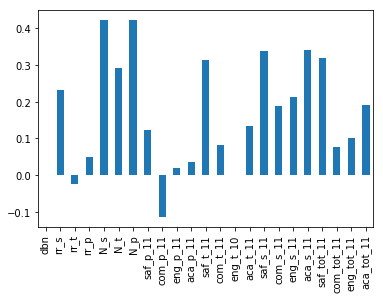

In [33]:
combined.corr()["sat_score"][survey_fields].plot.bar()

We can noticed that saf_t_11 and saf_s_11, which measure how teachers and students perceive safety at school, correlated highly with sat_score

Exploring Safety and SAT Scores

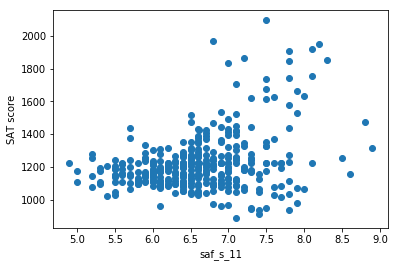

In [34]:
fig, ax = plt.subplots()
ax.scatter(combined['saf_s_11'], combined['sat_score'])
ax.set_xlabel("saf_s_11")
ax.set_ylabel("SAT score")
plt.show()

Exploring Race and SAT Scores

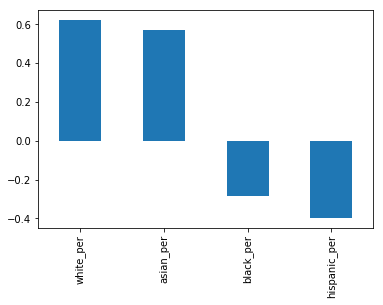

In [36]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()

From the bar plot above we can make conclusion than white and asian students have higher SAT score, may by it because this students more often live in more prosperous districts and have more comfortable condisions for learning

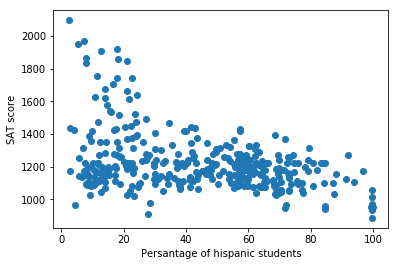

In [37]:
fig, ax = plt.subplots()
ax.scatter(combined['hispanic_per'], combined['sat_score'])
ax.set_xlabel("Persantage of hispanic students")
ax.set_ylabel("SAT score")
plt.show()

In [38]:
combined.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority05', 'priority06', 'priority07', 'priority08', 'priority09',
       'priority10', 'Location 1', 'lat', 'lon', 'school_dist'],
      dtype='object', length=161)

In [39]:
combined['hispanic_per'].head()

0    53.8
1    45.9
2    55.4
3    56.9
4    14.2
Name: hispanic_per, dtype: float64

In [40]:
comb_hisp_95 = combined[combined['hispanic_per'] >= 95]
comb_hisp_95.shape

(8, 161)

In [41]:
comb_hisp_95['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [42]:
print(combined[(combined['hispanic_per'] <= 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


We can find information about these schools in internet.

Exploring Gender and SAT Scores

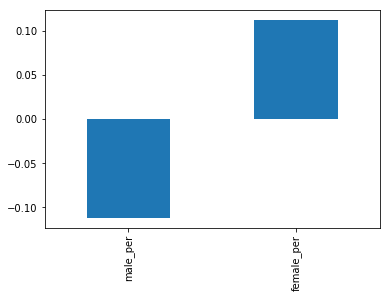

In [43]:
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar()

the higher female the higher SAT score

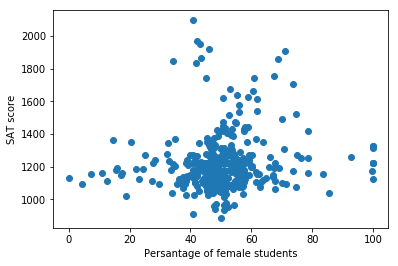

In [44]:
fig, ax = plt.subplots()
ax.scatter(combined['female_per'], combined['sat_score'])
ax.set_xlabel("Persantage of female students")
ax.set_ylabel("SAT score")
plt.show()

In [45]:
print(combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Exploring AP Scores vs. SAT Scores

In [46]:
ap_per = combined['AP Test Takers ']/combined['total_enrollment']

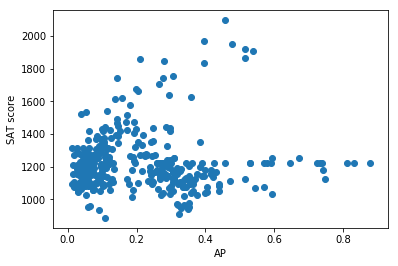

In [47]:
fig, ax = plt.subplots()
ax.scatter(ap_per, combined['sat_score'])
ax.set_xlabel("AP")
ax.set_ylabel("SAT score")
plt.show()

There is no an extremely strong correlation between AP and SAT score.

**Conclusion**:  
In this project we worked with several datasets, which consist different information about our subject. We prepared and combined this data sets. Analysis of data give us some dependencies:

- the safer the school, according to teachers and students, the higher the SAT score
- white and asian students have higher SAT score, may by it because this students more often live in more prosperous districts and have more comfortable condisions for learning
- the more Hispanics in school, the lower the SAT score
- the more girls at school, the higher the SAT score. 
For last two points we found names of school. Further we can find information about this school in internet to better understanding these dependencies.
We found that there is no an extremely strong correlation between AP and SAT score.